# Slide-Seq Mouse Colon
This example uses TACCO to annotate and analyse mouse colon Slide-Seq data with mouse colon scRNA-seq data as reference (Avraham-Davidi et al.).

(Avraham-Davidi et al.): Avraham-Davidi I, Mages S, Klughammer J, et al. Integrative single cell and spatial transcriptomics of colorectal cancer reveals multicellular functional units that support tumor progression. doi: https://doi.org/10.1101/2022.10.02.508492

In [1]:
import os
import sys
import matplotlib

import pandas as pd
import numpy as np
import anndata as ad

import tacco as tc

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

## Load data

In [2]:
data_path = common_code.find_path('results/slideseq_mouse_colon/data')
plot_path = common_code.find_path('results/slideseq_mouse_colon')
reference = ad.read(f'{data_path}/scrnaseq.h5ad')
puck = ad.read(f'{data_path}/slideseq.h5ad')

## Plotting options

In [3]:
highres = False
default_dpi = 100.0
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([4,3])*0.5

labels_colors = pd.Series({'Epi': (0.00784313725490196, 0.24313725490196078, 1.0), 'B': (0.10196078431372549, 0.788235294117647, 0.2196078431372549), 'TNK': (1.0, 0.48627450980392156, 0.0), 'Mono': (0.5490196078431373, 0.03137254901960784, 0.0), 'Mac': (0.9098039215686274, 0.0, 0.043137254901960784), 'Gran': (0.34901960784313724, 0.11764705882352941, 0.44313725490196076), 'Mast': (0.23529411764705882, 0.23529411764705882, 0.23529411764705882), 'Endo': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), 'Fibro': (0.6235294117647059, 0.2823529411764706, 0.0)})
region_colors = tc.pl.get_default_colors([f'region_{i}' for i in range(4)], offset=17)
split_names = np.array([f'sub_{i}' for i in range(4)])
split_colors = tc.pl.get_default_colors(split_names, offset=12)

## Visualize scRNA-seq data
Create UMAPs for the scRNA-seq data

SCumap...SCprep...time 7.727412223815918
time 68.7538959980011


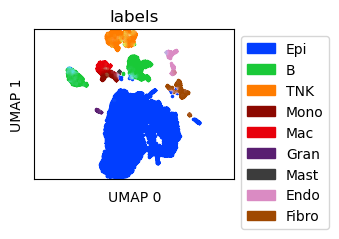

In [4]:
ref_umap = tc.utils.umap_single_cell_data(reference)
fig = tc.pl.scatter(ref_umap, keys='labels', position_key='X_umap', colors=labels_colors, joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Annotate the spatial data with compositions of cell types
Annotation is done on cell type level with multi_center=10 to capture variation within a cell type

In [5]:
tc.tl.annotate(puck,reference,'labels',result_key='labels',multi_center=10,);

Starting preprocessing
Annotation profiles were not found in `reference.varm["labels"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 14.11 seconds.
Starting annotation of data with shape (33673, 16879) and a reference of shape (17512, 16879) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=labels, normalize_to=adata
   +- multi center: multi_center=10 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.7410490029315331 10.559549576241444
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 23.6 seconds.


## Visualize the spatial cell type distribution

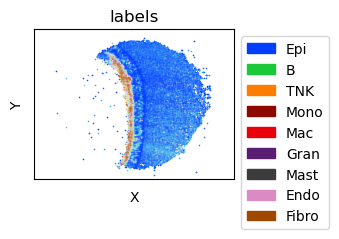

In [6]:
puck = puck[tc.sum(puck.X,axis=1)>=50].copy() # restrict downstream analysis to "good" beads
fig = tc.pl.scatter(puck, keys='labels', position_key=['x','y'], colors=labels_colors, joint=True, point_size=1, axsize=axsize, noticks=True, axes_labels=['X','Y']);

## Find spatially contiguous regions of comparable expression patterns 

In [7]:
tc.tl.find_regions(puck,key_added='regions',position_weight=1, resolution=0.55);
puck.obs['regions'] = puck.obs['regions'].map(lambda x: f'region_{x}').astype('category')

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [8]:
# ensure that the region naming is deterministic
ordered_regions = puck.obs.groupby('regions')['x'].mean().sort_values()
puck.obs['regions'] = puck.obs['regions'].map({r0:r1 for r0,r1 in zip(ordered_regions.index,['region_2','region_1','region_3','region_0'])}).astype(pd.CategoricalDtype(['region_0','region_1','region_2','region_3'],ordered=True))

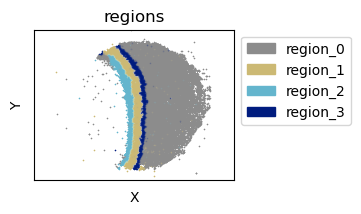

In [9]:
fig = tc.pl.scatter(puck,'regions',joint=True,axsize=axsize, point_size=1, noticks=True, axes_labels=['X','Y'], colors=region_colors);

## Get regularized distances from these regions

In [10]:
tc.tl.annotation_coordinate(puck,annotation_key='regions',result_key='region_dist',max_distance=500,delta_distance=20,sparse=False);

annotation_distance: The argument `distance_key` is `None`, meaning that the distance which is now calculated on the fly will not be saved. Providing a precalculated distance saves time in multiple calls to this function.
calculating distance for sample 1/1


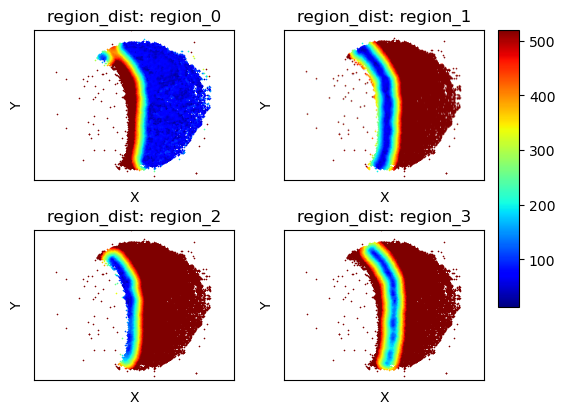

In [11]:
fig,axs=tc.pl.subplots(2,2,axsize=axsize,x_padding=0.5,y_padding=0.5)
axs=axs.flatten()[:,None]
fig = tc.pl.scatter(puck,'region_dist',cmap='jet', joint=False,axsize=axsize, point_size=1, noticks=True, axes_labels=['X','Y'], ax=axs);
for i in [-4,-2,-1]:
    fig.axes[i].remove()

Cell type composition at a certain regularized distance

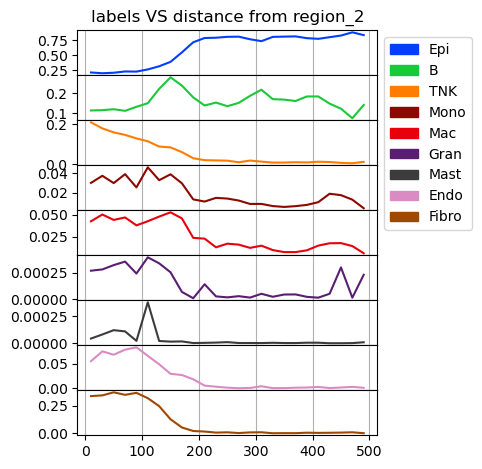

In [12]:
fig = tc.pl.annotation_coordinate(puck,annotation_key='labels',coordinate_key=('region_dist','region_2'),colors=labels_colors,max_coordinate=500,delta_coordinate=20, axsize=(3,0.45));

## Cell type composition in the regions

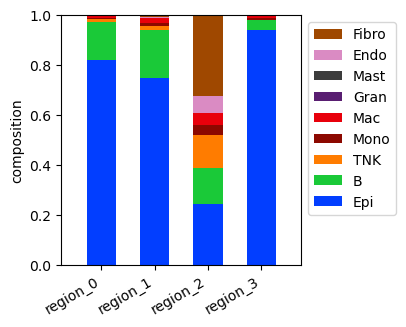

In [13]:
fig = tc.pl.compositions(puck, 'labels', 'regions', colors=labels_colors, axsize=(2.4,2.5));

## Subdivide the single spatial sample spatially into several parts

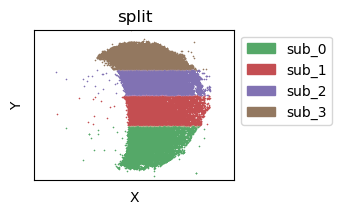

In [14]:
tc.utils.spatial_split(puck, position_key='y', position_split=4, result_key='split');
puck.obs['split'] = split_names[puck.obs['split'].astype('category').cat.codes]
puck.obs['split'] = puck.obs['split'].astype('category')
fig = tc.pl.scatter(puck, 'split', joint=True,axsize=axsize, point_size=1, noticks=True, axes_labels=['X','Y'], colors=split_colors);

Compare cell type composition across these parts

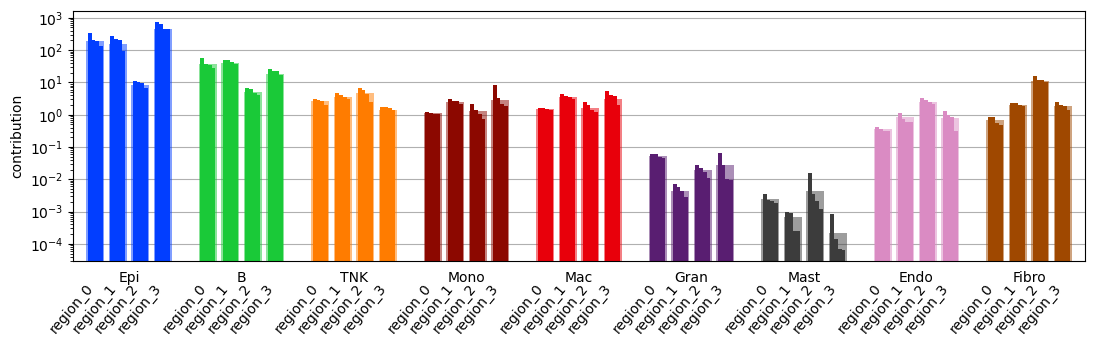

In [15]:
fig = tc.pl.contribution(puck, 'labels', 'regions', colors=labels_colors, normalization='gmean', reduction='sum', sample_key='split', axsize=(len(puck.obsm['labels'].columns) * (0.2 * 4 + .1) * 1.25, 2.5));

Do statistics on these parts treating them as independent samples

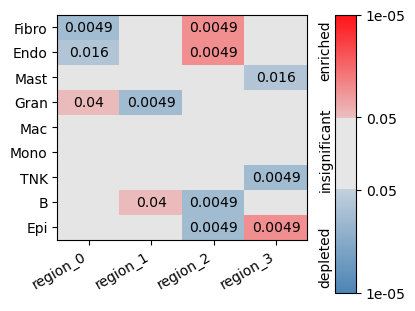

In [16]:
enr = tc.tl.enrichments(puck, 'labels', 'regions', normalization='gmean', reduction='sum', sample_key='split');
fig = tc.pl.significances(enr, p_key='p_mwu_fdr_bh', value_key='labels', group_key='regions', axsize=(2.5,len(puck.obsm['labels'].columns)*0.25));

## Analyse neighbourhips

co_occurrence: The argument `distance_key` is `None`, meaning that the distance which is now calculated on the fly will not be saved. Providing a precalculated distance saves time in multiple calls to this function.
calculating distance for sample 1/1
The heuristic value for the parameter `numba_blocksize` is 160.0. Consider specifying this directly as argument to avoid (possibly significant) overhead and/or experiment with this value on (a subset of) the actual dataset at hand to obtain an optimal value in terms of speed and memory requirements.


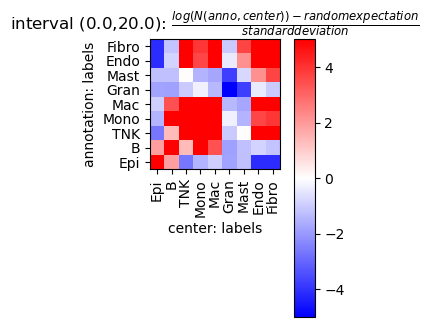

In [17]:
tc.tl.co_occurrence_matrix(puck,annotation_key='labels',result_key='labels-labels',max_distance=20,n_permutation=10, );
fig = tc.pl.co_occurrence_matrix(puck,analysis_key='labels-labels',score_key='z',cmap_vmin_vmax=(-5,5), axsize=(1.3,1.3));

## Analyse cell type composition relative to a region annotation
Calculate cell type composition in dependence of the distance to region_2.
In contrast to the analysis above using a gobally defined regularized distance, the distance here is defined for all pairs of observations and aggregated over the pairs.

co_occurrence: The argument `distance_key` is `None`, meaning that the distance which is now calculated on the fly will not be saved. Providing a precalculated distance saves time in multiple calls to this function.
calculating distance for sample 1/1
The heuristic value for the parameter `numba_blocksize` is 500.0. Consider specifying this directly as argument to avoid (possibly significant) overhead and/or experiment with this value on (a subset of) the actual dataset at hand to obtain an optimal value in terms of speed and memory requirements.


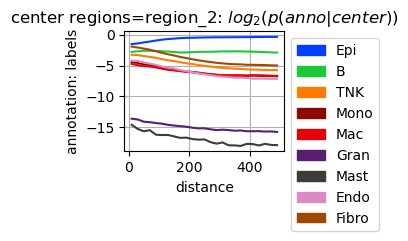

In [18]:
tc.tl.co_occurrence(puck,annotation_key='labels',center_key='regions',result_key='labels-regions',delta_distance=20,max_distance=500,n_permutation=10, );
fig = tc.pl.co_occurrence(puck,analysis_key='labels-regions',score_key='log_composition',colors=labels_colors, log_base=2, show_only_center=['region_2'], axsize=np.array([4,3])*0.4);